# Random Forest

The below contains the 8 step guide on the production of classification probability via Random Forest




In [26]:
%matplotlib notebook
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score,confusion_matrix,auc, roc_curve
from sklearn.calibration import CalibratedClassifierCV,calibration_curve
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
import random
from time import time
import matplotlib.pyplot as plt

In [27]:
# Step1: Train.xlsx Importation and Preprocessing
df1 = pd.read_excel('train.xlsx')
df1 = df1.dropna()

In [28]:
X_Independent = df1.iloc[:,1:-1]
X_Independent

,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,...,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6
0,1500,2,1,2,23,0,0,0,2,2.0,...,1482,1463,938.0,698.0,75,150,86,0,50.0,50.0
1,8500,2,2,2,29,0,0,0,0,0.0,...,8300,8364,8275.0,8425.0,300,400,315,300,325.0,305.0
2,1000,1,1,2,22,0,0,0,0,0.0,...,896,933,772.0,794.0,150,150,150,24,105.0,110.0
3,10500,1,1,1,31,0,0,0,0,0.0,...,7077,7190,7229.0,7340.0,255,260,258,260,265.0,307.0
4,10500,2,2,1,44,0,0,0,0,0.0,...,3533,3558,3592.0,3496.0,180,155,145,130,135.0,200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,12500,2,3,1,50,-2,-2,-2,-2,-2.0,...,0,0,1980.0,1019.0,408,0,0,1981,1019.0,1635.0
23996,1500,2,2,2,27,2,-1,0,0,-1.0,...,147,73,73.0,1402.0,149,73,0,73,1402.0,55.0
23997,7000,1,2,2,34,0,0,0,0,0.0,...,3146,3009,2946.0,2932.0,250,110,115,115,105.0,100.0
23998,8000,1,1,2,41,0,0,0,0,2.0,...,2242,2503,2457.0,2616.0,100,100,300,0,210.0,100.0


In [29]:
y_dependent = df1.iloc[:,-1]
y_dependent = y_dependent.replace({'yes':1,'no':0})


In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X_Independent, y_dependent, test_size = 0.2, random_state = 0)

In [31]:
smote = SMOTE(sampling_strategy ='minority') # Synthetic Minority Over-Sampling Technique
X_sm, y_sm = smote.fit_sample(X_train,y_train)
y_sm.groupby(y_sm).count()


default_oct
0    14154
1    14154
Name: default_oct, dtype: int64

In [32]:
#Step2: GridSearch Hyperparameter (Model training and validation)

clf = RandomForestClassifier()
tuned_parameters = {'max_features':[0.1,0.3,0.6,0.9], 'n_estimators':[40,50,60,70]}
grid_clf_acc = GridSearchCV(clf, param_grid = tuned_parameters)
grid_clf_acc.fit(X_sm, y_sm)
print('Grid Best Parameter (max.accuracy): ', grid_clf_acc.best_params_)
print('Grid best score (accuracy):', grid_clf_acc.best_score_)

Grid Best Parameter (max.accuracy):  {'max_features': 0.1, 'n_estimators': 70}
Grid best score (accuracy): 0.8466190960840534


In [33]:
# Step3: Model Training with Tuned Hyperparameter

RF_predicted = RandomForestClassifier(max_features = 0.1, n_estimators = 70,random_state= 0).fit(X_train, y_train) # from 0.9 to 0.1

RF_predicted_score = RF_predicted.score(X_test, y_test)
print('Accuracy score on Testing Data', RF_predicted_score)
print ('Feature important:', RF_predicted.feature_importances_)

Accuracy score on Testing Data 0.813295304958315
Feature important: [0.06306451 0.01355494 0.02211671 0.0149251  0.06716564 0.08648967
 0.03956856 0.02742711 0.02005233 0.02774403 0.02335711 0.05906585
 0.05541975 0.05258838 0.05103751 0.05120276 0.05102826 0.04973852
 0.04657749 0.04649661 0.04244963 0.04257501 0.04635452]


In [34]:
# Step4: Model Evaluation with ROC Curve

y_score_RF = RF_predicted.predict_proba(X_test)
fpr_RF, tpr_RF, _ = roc_curve(y_test, y_score_RF[:,1])
roc_auc_RF = auc(fpr_RF, tpr_RF)
print('AUC score:', roc_auc_RF)

AUC score: 0.7555299543815299


<IPython.core.display.Javascript object>


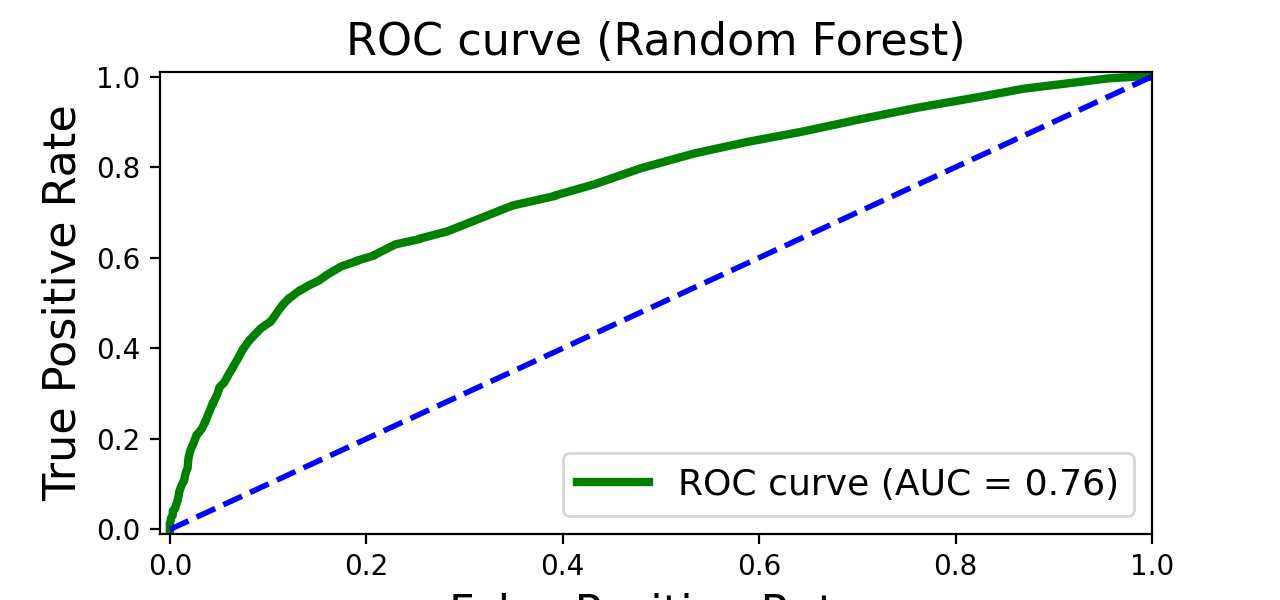

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


In [54]:


fig = plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
fig.set_figheight(3)
plt.plot(fpr_RF, tpr_RF, lw=3, color = 'green', label='ROC curve (AUC = {:0.2f})'.format(roc_auc_RF))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (Random Forest)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], color='blue', lw=2, linestyle='--')
plt.axes().set_aspect('auto')
plt.show()

<IPython.core.display.Javascript object>


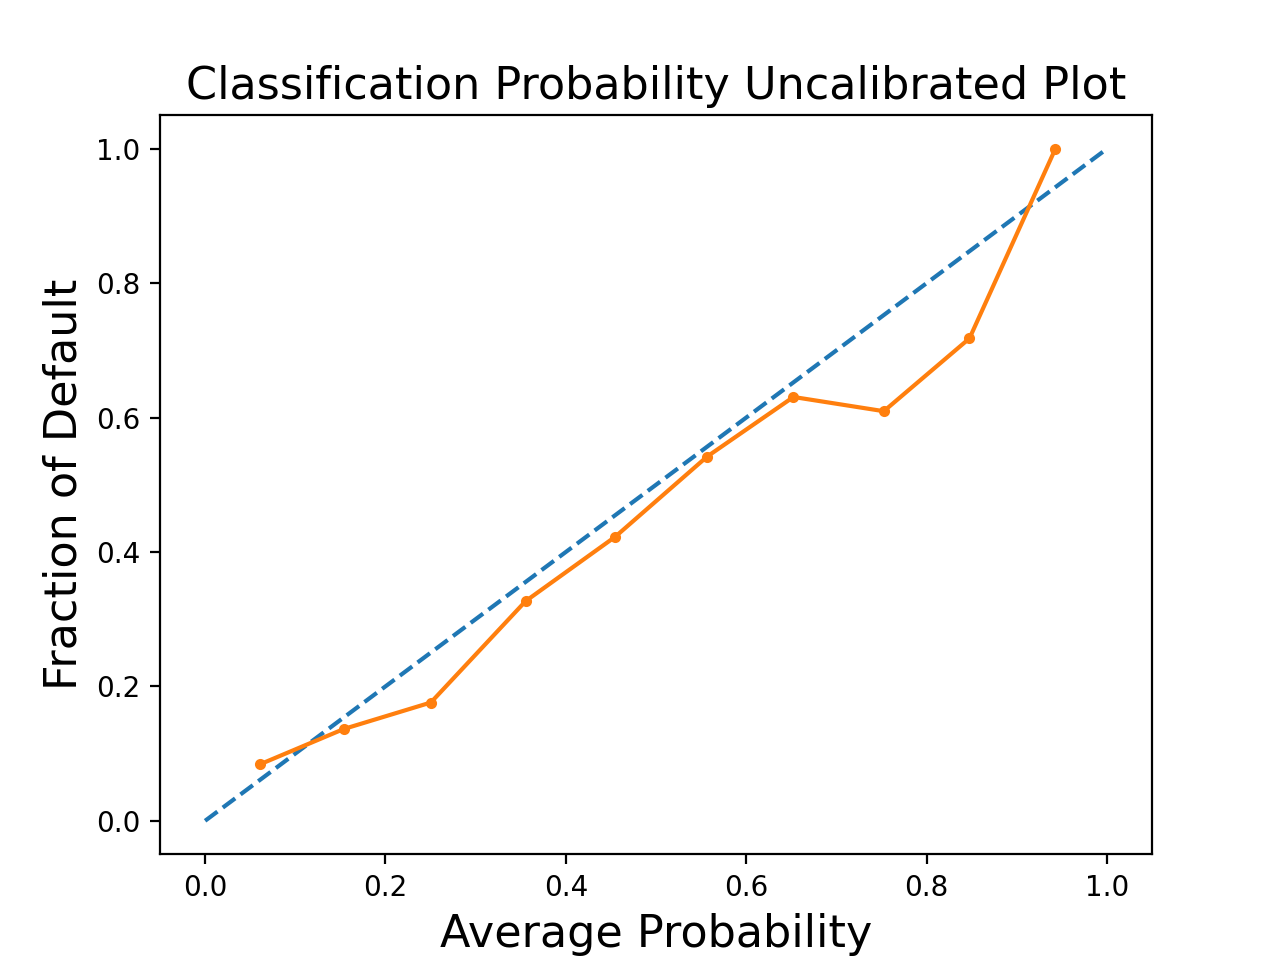

In [36]:
# Step5: Model Evaluation with Calibration Curve






fop, mpv = calibration_curve(y_test,y_score_RF[:,1], n_bins = 10)
plt.figure()
plt.plot([0,1],[0,1], linestyle = '--')
plt.plot(mpv, fop, marker = '.')
plt.ylabel('Fraction of Default', fontsize=16)
plt.xlabel('Average Probability', fontsize=16)
plt.title('Classification Probability Uncalibrated Plot', fontsize=16)
plt.show()



<IPython.core.display.Javascript object>


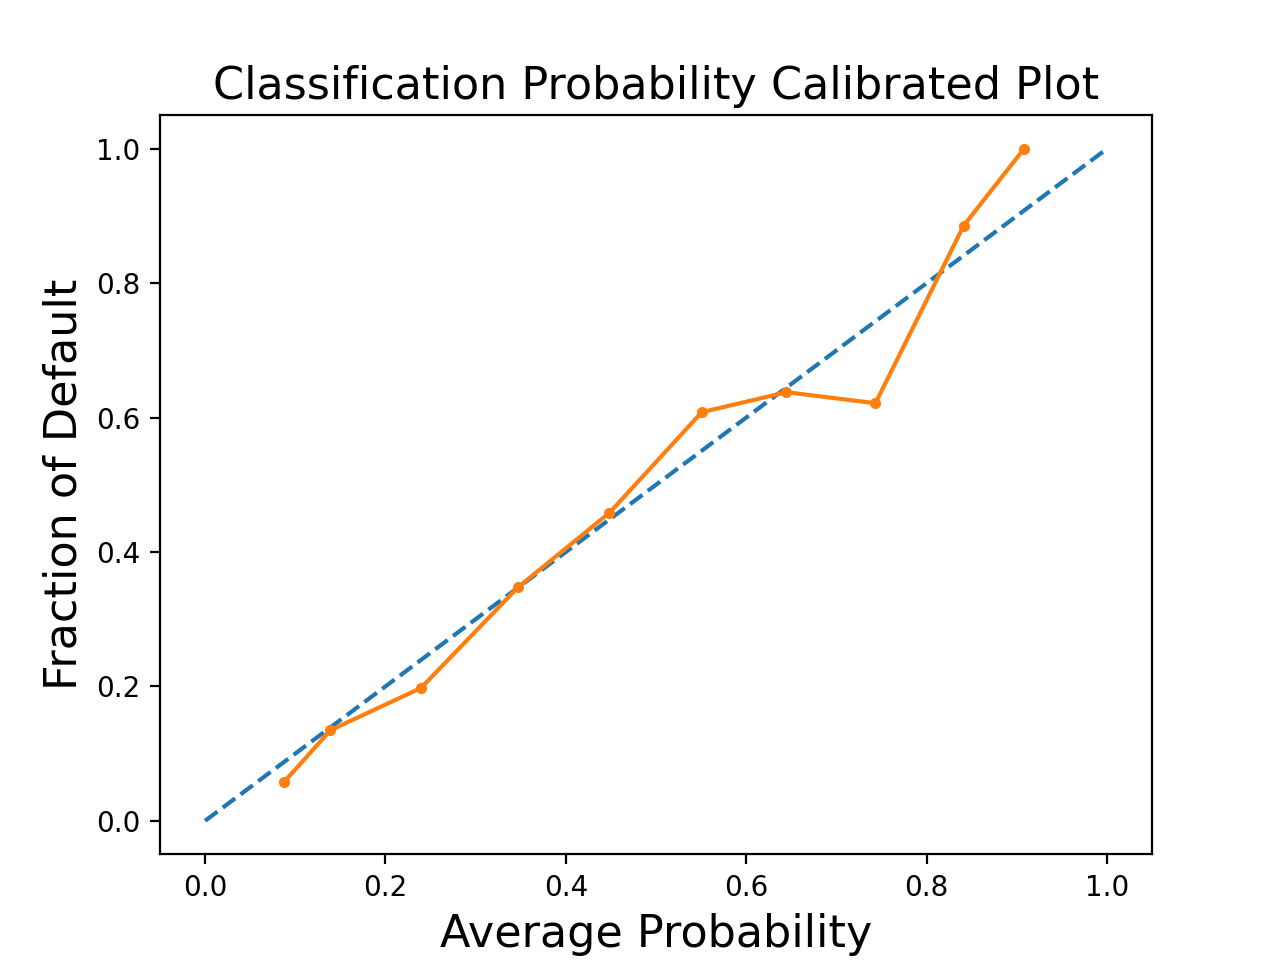

In [37]:

clf1 = RandomForestClassifier(max_features = 0.1, n_estimators = 70,random_state= 0) # from 0.9 to 0.1

# The training data fit into clf1 (RF) and transform the test data for 5 times/folds
calibrated = CalibratedClassifierCV(clf1, method = 'sigmoid', cv = 5) 
calibrated.fit(X_train,y_train)
probs = calibrated.predict_proba(X_test)[:,1]



fop, mpv = calibration_curve(y_test, probs, n_bins=10)

plt.figure()
plt.plot([0,1],[0,1], linestyle='--')
plt.ylabel('Fraction of Default', fontsize=16)
plt.xlabel('Average Probability', fontsize=16)
plt.title('Classification Probability Calibrated Plot', fontsize=16)
plt.plot(mpv, fop, marker= '.')
plt.show()


In [38]:
# Step6: Test.xlsx Importation and Preprocessing



Test_df = pd.read_excel('test.xlsx')
Test_df.fillna(Test_df.median(), inplace = True)
Test_x = Test_df.iloc[:,1:]
Test_X_customer_id = Test_df.iloc[:,0]
Test_x.isnull().any()

limit_bal    False
sex          False
education    False
marriage     False
age          False
pay_1        False
pay_2        False
pay_3        False
pay_4        False
pay_5        False
pay_6        False
bill_amt1    False
bill_amt2    False
bill_amt3    False
bill_amt4    False
bill_amt5    False
bill_amt6    False
pay_amt1     False
pay_amt2     False
pay_amt3     False
pay_amt4     False
pay_amt5     False
pay_amt6     False
dtype: bool

In [39]:
# Step7: Applying Tuned Random Forest with Tuned predict_proba on Test.xlsx


Test_y = calibrated.predict_proba(Test_x)[:,1]
Test_y_df = pd.DataFrame(Test_y)
Test_X_customer_id_df = pd.DataFrame(Test_X_customer_id) 




In [40]:
Final = pd.concat([Test_X_customer_id_df, Test_y_df], axis = 1)
Final.rename(columns = {0:'pr_y'}, inplace = True)
Final

,customer_id,pr_y
0,24002,0.089178
1,24003,0.127054
2,24004,0.650673
3,24005,0.534726
4,24006,0.432848
...,...,...
5994,29996,0.278076
5995,29997,0.123403
5996,29998,0.218940
5997,29999,0.395690


In [41]:
Final.shape

(5999, 2)

In [42]:
# Step 8: Data Export 
def make_submission(name, data_frame):
    """
    Parameters:
    -----------
        name:               string, your name
        data_frame:         pandas DataFrame [5999, 2], customer ids and 
                                predicted probabilities on the test set
    """
    cnames = data_frame.columns.values
    if not isinstance(data_frame, pd.DataFrame):
        raise ValueError('Expecting a pandas DataFrame for argument 2')
    elif cnames[0] != 'customer_id':
        raise ValueError('Column name 0 incorrect, expecting customer_id, received ' + cnames[0])
        
    t0 = time()
    filename = name + '.csv'
    data_frame.to_csv(filename, index = False)
    return '{fname} written in {t:.{rd}f} ms'.format(fname = filename, t = (time() - t0) / 1000., rd = 3)


In [43]:
Name1 = 'Sen_Hin_Edgar_Tse_predictions'

In [44]:
make_submission(Name1, Final)

'Sen_Hin_Edgar_Tse_predictions.csv written in 0.000 ms'